In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Get column names for Measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ef7db2df60>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

In [10]:
# Get column names for Station
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ef7db2cfa0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [12]:
# Convert most recent date to datetime
date_format = '%Y-%m-%d'
old_date = dt.datetime.strptime(most_recent_date.date, date_format)

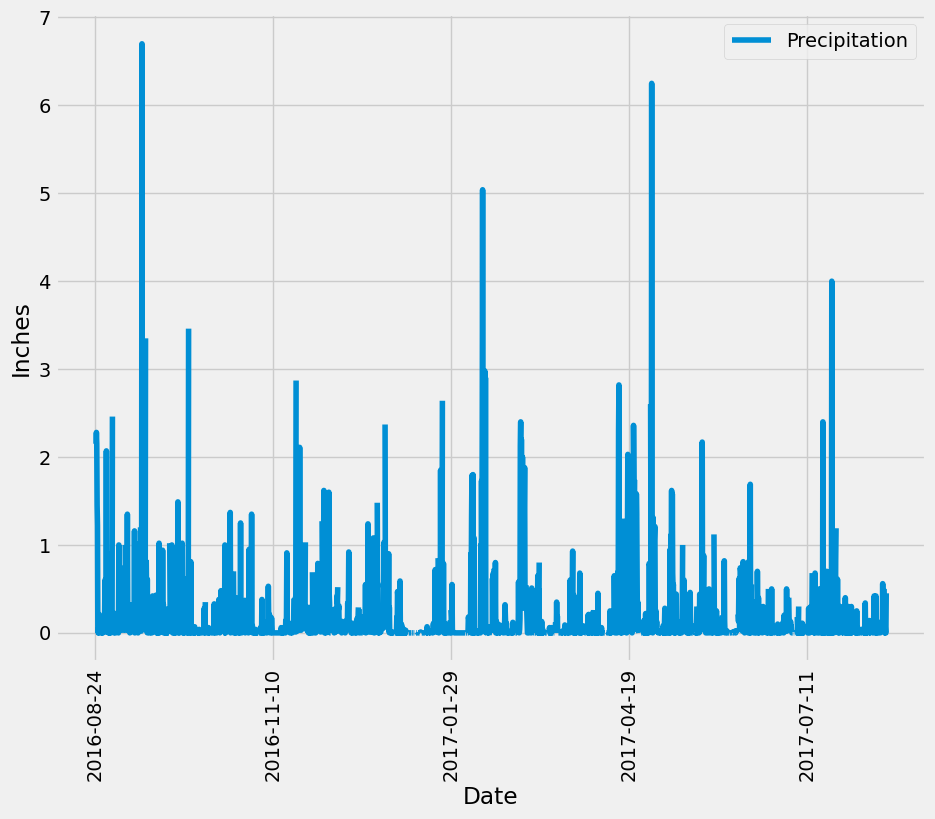

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_earlier = old_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_earlier)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query.statement, query.session.bind).rename(columns={"date" : "Date", "prcp" : "Precipitation"})

# Sort the dataframe by date
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plot = df.plot(ylabel='Inches', rot=90, figsize=(10,8))

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = pd.DataFrame(df['Precipitation'].describe())
stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_group = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
station_group.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Which station id has the greatest number of observations?
most_obs = station_group.first().station
print(f'{most_obs} has the most observations.')

USC00519281 has the most observations.


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_obs_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_obs)
most_obs_stats.all()

[(54.0, 85.0, 71.66378066378067)]

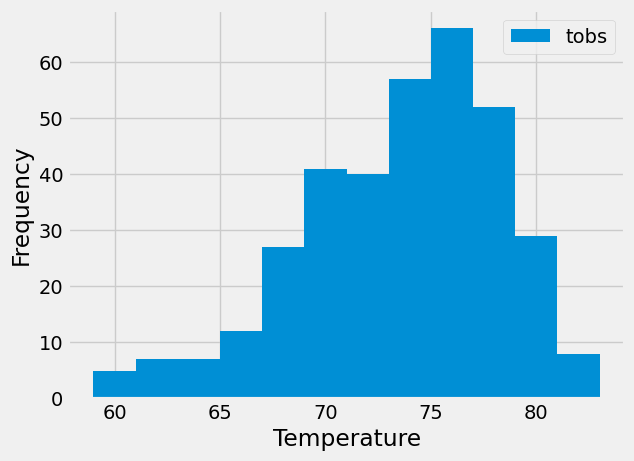

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query
most_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_earlier).filter(Measurement.station == most_obs)

# Save the query results as a Pandas DataFrame
most_df = pd.read_sql(most_query.statement, most_query.session.bind)

# Sort the dataframe by tobs
most_df = most_df.sort_values(by='tobs')

# Use Pandas Plotting with Matplotlib to plot the data as a histogram
plot = most_df.plot(kind='hist',xlabel='Temperature', bins=12)

# Close Session

In [20]:
# Close Session
session.close()